In [1]:
from manipulation_library_dev import get_image, get_colors, OcrAnalysis ,map_color_to_pixels , count_pixel_colors ,RGB2HEX
import pandas as pd
import easyocr , os , ssl
import matplotlib.pyplot as plt
import numpy as np
ssl._create_default_https_context = ssl._create_unverified_context

In [2]:
from glob import glob

In [3]:
my_dictionary_of_images = {
    'T2_CTRL_DAY-1':54,
    'T1_BMC_DAY-1':25,
    'T1_CTRL_NIGHT-3':45,
    'T1_CTRL_NIGHT-1':43, 
    'T2_BMC_Night-4':55,
    'T1_CTRL_DAY-5':35
    } 

In [4]:
reader = easyocr.Reader(['en'],gpu=True) # this needs to run only once to load the model into memory

In [5]:
# 2nd Gather all the cropped parts from the images 

# %%
path_to_folder = "/".join(os.getcwd().split("/")[:-1])

# "output/Fragments_CoralChart/Dispenser_Project_Fragments_CoralChart/cropped_images/"
segment_enhanced = "output/Fragments_CoralChart/Dispenser_Project_Fragments_CoralChart/cropped_images/center_fragment"
path_absolute_to_image = os.path.join(path_to_folder,segment_enhanced)
segment_center_images = f"{path_absolute_to_image}/*.jpg"
list_of_center_segment_images_enhanced = glob(segment_center_images)

file_name = [ x.split("/")[-1].split("-center")[0] for x in list_of_center_segment_images_enhanced ]

# my_path = "output/Enhanced_Images_Dispenser_ImagingPAM_Fragments"
my_path = "output/Fragments_CoralChart/Dispenser_Project_Fragments_CoralChart/cropped_images"
path_to_images_folder = os.path.join(path_to_folder,my_path)
section = ["up","down","rigth","left"]
my_images ={}
for f_name in file_name:
    inner_dict = {} 
    for sec in section :
        image_path = os.path.join(path_to_images_folder, sec, f"{f_name}-{sec}.jpeg")
        if os.path.isfile( image_path): 
            inner_dict[sec] = image_path
        else : 
            print (f"file not found :{path_to_images_folder}/{sec}/{f_name}-{sec}.jpeg")
    if inner_dict :
         my_images[f_name] = inner_dict

In [6]:
# %% [markdown]
# Build the color chart 
# %%
custom_color_charts = {}
incomplete_to_fill = []
for f_name in file_name:
        my_personal_chart = {}
        # print(f_name)

        for sec in section :
            im =  my_images[f_name][sec]
            # print(im)
            result = reader.readtext(im)
            bboxes, text_list = OcrAnalysis.get_bounding_boxes(result)

            #if len(text_list) == 6 :
                #print(f_name,sec,len(text_list))
            image = get_image(im)

            for t,bbox in zip(text_list,bboxes):
                cropped_image = OcrAnalysis.get_pixels_above_bbox(bbox=bbox,image=image)
                df_color = get_colors(image=cropped_image, number_of_colors=1, show_chart=False)
                my_personal_chart[t]=tuple( round(x) for x in df_color["rgb_colors"][0].tolist() )

        if my_personal_chart:

            new_keys = ['E1', 'E2', 'E3', 'E4', 'E5', 'E6', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6']
            if len(new_keys) == len(my_personal_chart.keys()):
                my_personal_chart = {new_keys[i]: my_personal_chart[old_key] for i, old_key in enumerate(my_personal_chart)}
                my_personal_chart["Black"] = tuple([0,0,0])
                my_personal_chart["White"] = tuple([255,255,255])
                custom_color_charts[f_name] = my_personal_chart
            else :
                #print (f"not complete:{f_name}")
                incomplete_to_fill.append(f_name)


In [7]:
# %%
my_custom_keys = [x for x in custom_color_charts.keys()]
for idx , f_name in enumerate (incomplete_to_fill):
    r_name = my_custom_keys[idx]
    print (f"filling {f_name} with {r_name}" )
#    #del custom_color_charts[f_name]
    custom_color_charts[f_name] ={ key:item for (key,item) in custom_color_charts[r_name].items()}

filling T1_CTRL_Night-4 with T0_CTRL_Day-6
filling T0_CTRL_Night-3 with T1_BMC_Night-3


In [8]:
# %%
for im in list_of_center_segment_images_enhanced: 
    # print (im)
    # local_image = get_image(im)
    name = im.split("/")[-1]
    key = im.split("/")[-1].split("-center")[0]
    if key in custom_color_charts.keys():
        if len(custom_color_charts[key]) == 26:
            pass
        else:
            print (key,len(custom_color_charts[key]))

In [9]:
outputs = "output/Enhanced_Images_Dispenser_ImagingPAM_Fragments/mapped_color_images_pt2"
path_absolute_to_output = os.path.join(path_to_folder,outputs)
os.makedirs(path_absolute_to_output ,exist_ok=True)
# print (path_absolute_to_output)

In [10]:
# create a function to convert all the black pixels to white 
def convert_black_to_white(image):
    image = np.array(image)
    image[np.where((image == [0,0,0]).all(axis=2))] = [255,255,255]
    return image

In [11]:
def convert_gray_to_white(image):
    """Converts all shades of gray pixels to white in an image.

    Args:
        image: The input image as a NumPy array.

    Returns:
        The modified image with gray pixels converted to white.
    """

    image = np.array(image)  # Ensure it's a NumPy array

    # Create a mask for all pixels that are shades of gray
    # gray_mask = np.all(image == image[:, :, 0], axis=-1)
    gray_mask = np.all(image[:, :, 1:] == image[:, :, 0:1], axis=-1)


    # Expand the dimensions of the mask to match the image shape
    # gray_mask = np.expand_dims(gray_mask, axis=-1)

    # Set the pixels in the mask to white
    image[gray_mask] = [255, 255, 255]

    return image

In [12]:
def plot_compare_mapped_image_save(img1_rgb,filename,color_map_RGB,title):

    # get the mapped image 
    mapped_image , color_map , color_to_pixels = map_color_to_pixels(image=img1_rgb, color_map_RGB=color_map_RGB )
    del color_map['Black'] 
    del color_to_pixels['Black']
    # for color, pixels in color_to_pixels.items():
    #     print(f"Color: {color}")
    #     print(f"Max: {np.max(pixels)}")
    #     print(f"Min: {np.min(pixels)}")
    #     print(f"Std: {np.std(pixels)}")
    #     print(f"Mean: {np.mean(pixels)}")

    color_counts, reverse_dict = count_pixel_colors(image=mapped_image , color_map_RGB=color_map)

    # lists = sorted(reverse_dict.items()) # sorted by key, return a list of tuples
    lists = sorted(reverse_dict.items(), key=lambda kv: kv[1], reverse=True)

    # color_name, percentage_color_name = zip(*lists) # unpac the tupple
    color_name, percentage_color_name , max_val , min_val , mean_val , std_val  = [],[], [],[],[], []
    for c , p in lists:
        # print (c,p)
        if p > 1 :
            color_name.append(c)
            percentage_color_name.append(p)
            max_val.append ( np.max(color_to_pixels[c]) )
            min_val.append ( np.min(color_to_pixels[c]) ) 
            mean_val.append( np.mean(color_to_pixels[c]))
            std_val.append( np.std(color_to_pixels[c]))

    hex_colors_map = [RGB2HEX(color_map[key]) for key in color_name]

    results_df = pd.DataFrame({
    'color_name': color_name,
    'percentage_color_name': percentage_color_name,
    'hex_colors_map': hex_colors_map,
    'Mean_dist_val': mean_val,
    'Std_dist_val': std_val , 
    'Max_dist_val': max_val,
    'Min_dist_val': min_val
    })
    result_name = filename.replace(".jpg",".csv")
    results_df.to_csv(result_name)

    # apply convert_black_to_white
    img1_rgb = convert_black_to_white(img1_rgb)
    mapped_image = convert_black_to_white(mapped_image)
    img1_rgb = map_white_pixels(source_image=mapped_image,target_image=img1_rgb)




    # Create a figure and subplots
    fig, (ax1, ax2, ax3 ) = plt.subplots(nrows=1,ncols=3,figsize=(15, 5))  # Adjust figsize as needed
    # plt.title(label=filename.split("/")[-1].split(".")[0])
    plt.title(label=title)
    # Display the images
    ax1.imshow(img1_rgb)
    ax1.set_title("Original")
    ax1.axis('off') 

    ax2.imshow(mapped_image)
    ax2.set_title("Mapped Image")
    ax2.axis('off') 


    # ax2.set_ylabel("Mapped Image")
    # ax2.set_xlabel("Color code in chart")

    # ax3.bar(color_name, percentage_color_name, color = hex_colors_map , edgecolor='black' )
    ax3.bar(color_name, percentage_color_name, color = hex_colors_map )
    # Remove the tick marks; they are unnecessary with the tick lines we just
    # plotted. Make sure your axis ticks are large enough to be easily read.
    # You don't want your viewers squinting to read your plot.
    ax3.tick_params(axis='both', which='both', labelsize='large',
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)


    ax3.yaxis.grid(True, linestyle='--', which='major',color='grey', alpha=.25)
    ax3.set_xlabel("Color code in chart")
    ax3.set_ylabel("Percentage of pixel on the image")
    plt.xticks(rotation=90)
    # plt.tick_params(top='off', bottom='off', left='off', right='off')

    
    # plt.xlabel("Color code in chart")
    # plt.ylim(lower_y_limit,higher_y_limit)

    # Adjust spacing between subplots
    plt.tight_layout()
    #
    plt.savefig(fname=filename ,transparent=True ,format='jpg', dpi=300)
    # save the image with the highest quality possible
    # filename = filename.replace()
    result_name = filename.replace(".jpg",".svg")
    plt.savefig(fname=result_name ,transparent=True ,format='svg', dpi=300)
    # use close to dont show all images at once 
    plt.close()

In [13]:
def map_white_pixels(source_image, target_image):
    """Maps white pixels from the source image to the target image.

    Args:
        source_image: The source image as a NumPy array.
        target_image: The target image as a NumPy array.

    Returns:
        A modified target image with the white pixels from the source mapped onto it.
    """

    # Ensure both images have the same dimensions
    if source_image.shape != target_image.shape:
        raise ValueError("Source and target images must have the same dimensions.")

    # Create a mask for white pixels in the source image
    source_white_mask = np.all(source_image == 255, axis=-1)

    # Map white pixels from source to target based on their positions
    target_image[source_white_mask] = source_image[source_white_mask]

    return target_image

In [14]:
# %%
for key in my_dictionary_of_images.keys():
    for im in list_of_center_segment_images_enhanced: 
    # print(im)
    # print (os.path.basename(im))
        file_code_name = os.path.basename (im).split("-center")[0]
        # print (key , file_code_name)
        if key.lower() == file_code_name.lower():
                print ( file_code_name, key)

                local_image = get_image(im)
                name = im.split("/")[-1]
                if len(custom_color_charts[file_code_name]) == 26:
                    path_name = os.path.join(path_absolute_to_output,name)
                    plot_compare_mapped_image_save( local_image,path_name,custom_color_charts[file_code_name],my_dictionary_of_images[key] )
                    # OcrAnalysis.plot_custom_colorchart(custom_color_charts[file_code_name])


T2_CTRL_Day-1 T2_CTRL_DAY-1
T1_BMC_Day-1 T1_BMC_DAY-1
T1_CTRL_Night-3 T1_CTRL_NIGHT-3
T1_CTRL_Night-1 T1_CTRL_NIGHT-1
T2_BMC_Night-4 T2_BMC_Night-4
T1_CTRL_Day-5 T1_CTRL_DAY-5


In [15]:
custom_color_charts.keys()

dict_keys(['T0_CTRL_Day-6', 'T1_BMC_Night-3', 'T1_CTRL_Day-1', 'T1_CTRL_Day-4', 'T1_BMC_Night-5', 'T1_BMC_Day-2', 'T0_CTRL_Night-5', 'T1_CTRL_Night-2', 'T1_CTRL_Night-1', 'T1_CTRL_Day-3', 'T2_BMC_Day-6', 'T2_BMC_Day-3', 'T0_BMC_Night-3', 'T0_BMC_Day-4', 'T2_CTRL_Day-3', 'T2_BMC_Night-4', 'T0_BMC_Day-2', 'T0_BMC_Night-6', 'T1_BMC_Day-5', 'T0_CTRL_Day-2', 'T1_BMC_Day-1', 'T0_CTRL_Day-3', 'T2_BMC_Night-6', 'T1_BMC_Day-6', 'T1_CTRL_Night-3', 'T0_CTRL_Night-4', 'T1_BMC_Night-4', 'T1_CTRL_Day-5', 'T2_CTRL_Night-6', 'T0_BMC_Day-6', 'T0_BMC_Night-5', 'T1_CTRL_Day-6', 'T0_CTRL_Night-6', 'T1_BMC_Night-2', 'T0_CTRL_Night-2', 'T0_BMC_Day-1', 'T2_CTRL_Day-1', 'T2_BMC_Night-3', 'T2_BMC_Day-2', 'T0_CTRL_Night-1', 'T2_CTRL_Night-4', 'T0_CTRL_Day-4', 'T2_CTRL_Night-2', 'T0_BMC_Day-5', 'T2_BMC_Day-4', 'T0_BMC_Night-4', 'T0_BMC_Night-2', 'T2_CTRL_Day-4', 'T2_BMC_Night-1', 'T0_BMC_Night-1', 'T1_CTRL_Night-6', 'T2_CTRL_Night-3', 'T1_BMC_Day-4', 'T1_BMC_Day-3', 'T2_BMC_Night-5', 'T2_BMC_Day-1', 'T1_CTRL_Day

In [16]:
# from manipulation_library import show_box
# for sec in section :

#     im =  my_images["T2_BMC_Night-4"][sec]
#             # print(im)
#     result = reader.readtext(im)
#     bboxes, text_list = OcrAnalysis.get_bounding_boxes(result)

#             #if len(text_list) == 6 :
#                 #print(f_name,sec,len(text_list))

#     image = get_image(im)
#     plt.figure(figsize=(20, 20))
#     plt.imshow(image)
#     # show_mask(masks[0], plt.gca())
#     for input_box in bboxes : 
#         show_box(input_box, plt.gca())


#     plt.axis('off')
#     plt.show()

    

            # for t,bbox in zip(text_list,bboxes):
            #     cropped_image = OcrAnalysis.get_pixels_above_bbox(bbox=bbox,image=image)
            #     df_color = get_colors(image=cropped_image, number_of_colors=1, show_chart=False)
            #     my_personal_chart[t]=tuple( round(x) for x in df_color["rgb_colors"][0].tolist() )




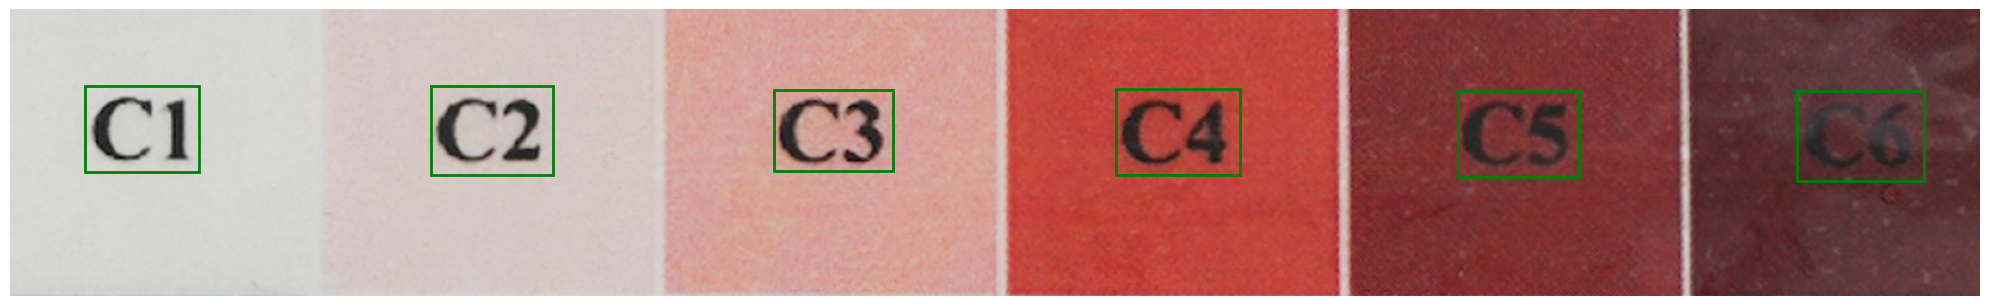

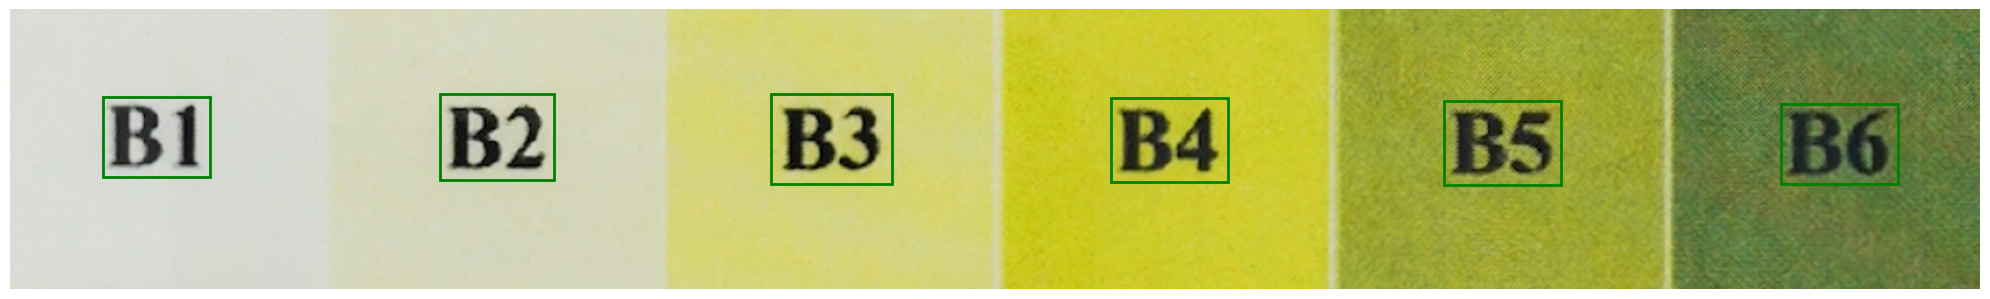

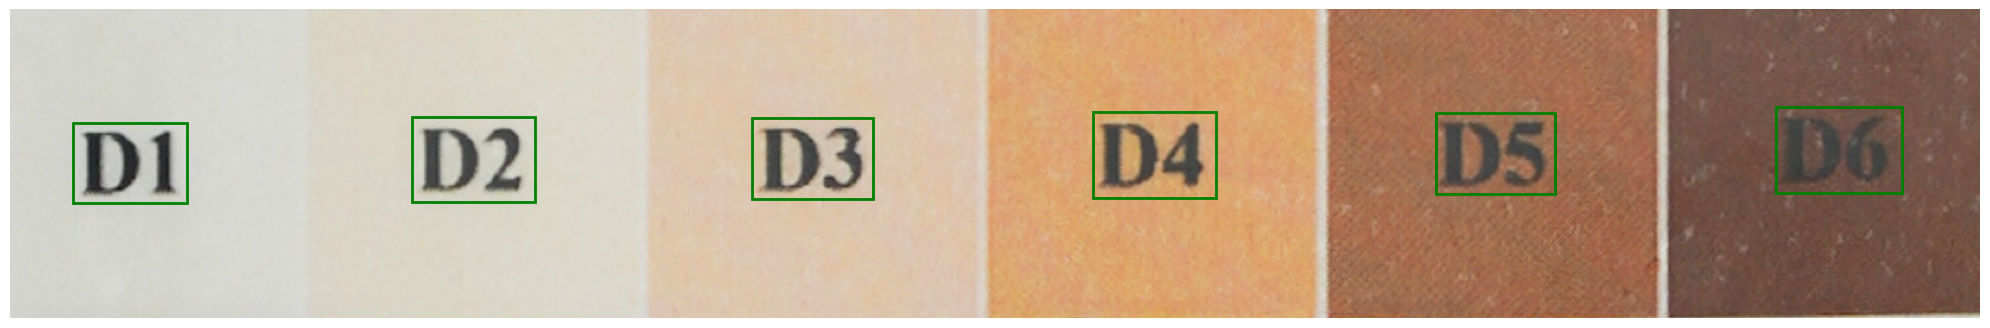

In [17]:
from manipulation_library import show_box

for sec in section :

    im =  my_images["T2_BMC_Night-4"][sec]
            # print(im)
    result = reader.readtext(im)
    bboxes, text_list = OcrAnalysis.get_bounding_boxes(result)

            #if len(text_list) == 6 :
                #print(f_name,sec,len(text_list))

    image = get_image(im)
    fig, ax = plt.subplots(figsize=(20, 20))
    ax.imshow(image)
    # show_mask(masks[0], plt.gca())
    for input_box in bboxes : 
        show_box(input_box, ax)


    plt.axis('off')

    plt.tight_layout()

    # Save figure in SVG format
    svg_file_name = f"image_{sec}.svg"
    path_name = os.path.join(path_absolute_to_output,svg_file_name)

    fig.savefig(path_name, format='svg', bbox_inches='tight', pad_inches=0)

    # Save figure in JPG format with DPI 300
    jpg_file_name = f"image_{sec}.jpg"
    path_name = os.path.join(path_absolute_to_output,jpg_file_name)

    fig.savefig(path_name, format='jpg', dpi=300, bbox_inches='tight', pad_inches=0)
    
    plt.show()

In [18]:
input_coral_image = "input/BMC_D_04_10-12.jpg"

In [19]:
path_absolute_to_image = os.path.join(path_to_folder,input_coral_image)


In [20]:
from manipulation_library import show_images_grid, load_sam_model, process_images
import cv2

In [21]:
mask_generator = load_sam_model()

CUDA is available!


In [22]:
# path_to_coral ='../input/bleached_coral/B1_P1_AC_09-17.JPG'
image = get_image(path_absolute_to_image)
width_original = image.shape[1] 
height_original = image.shape[0] 
image = cv2.resize(image, (1800,1200), interpolation = cv2.INTER_AREA)
masks = mask_generator.generate(image)
list_of_images, titles  = process_images(image = image, masks= masks)

In [23]:
show_images_grid( images=list_of_images , titles=titles )